In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:

import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bayes_opt import BayesianOptimization
from dotenv import find_dotenv, load_dotenv
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)
from sklearn.tree import ExtraTreeRegressor

from src.visualization.visualize import (
    crossvalidate_pipeline_scores,
    plot_scores,
    train_and_plot_prediction_metrics,
)

# Setting styles
sns.set(style="whitegrid", color_codes=True, rc={"figure.figsize": (12.7, 9.27)})

random_state = 123



In [2]:

data = pd.read_csv(os.path.join("data", "processed", "galaxy.csv"))


In [3]:

target = "galaxysentiment"

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=target), data[target], test_size=0.2, random_state=random_state
)


 # Optimizing the Hyperparameters for Model Without Feature Selection

 * Using scoring metric of mean squared error

In [4]:


# def rf_cv(n_estimators, max_depth, min_samples_split):
#     pipeline = make_pipeline(
#         VarianceThreshold(),
#         RandomForestRegressor(
#             n_estimators=int(n_estimators),
#             max_depth=int(max_depth),
#             min_samples_split=int(min_samples_split),
#             n_jobs=3,
#             random_state=random_state,
#         ),
#     )
#     cv_scores = cross_val_score(
#         pipeline, X_train, y_train, cv=3, scoring="neg_mean_squared_error"
#     )
#     return cv_scores.mean()


# parameter_bounds = {
#     "n_estimators": (10, 1000),
#     "max_depth": (1, 150),
#     "min_samples_split": (2, 10),
# }

# optimizer = BayesianOptimization(
#     f=rf_cv, pbounds=parameter_bounds, verbose=2, random_state=random_state
# )

# optimizer.maximize(init_points=20, n_iter=100)
# print(optimizer.max)



 # Feature Selection

 * We do the feature selection with RFECV using random forest also as its model

In [5]:

selector = RFECV(
    RandomForestRegressor(
        n_estimators=436,
        max_depth=14,
        min_samples_split=5,
        n_jobs=3,
        random_state=random_state,
    ),
    step=1,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=3,
)
selector = selector.fit(X_train, y_train)
columns_to_keep = X_train.columns[selector.support_]
print("Columns to keep:", columns_to_keep)
print(
    "Proportion of features kept:",
    round(len(columns_to_keep) * 100 / len(X_train.columns), 1),
    "%",
)



Columns to keep: Index(['iphone', 'samsunggalaxy', 'ios', 'googleandroid', 'iphonecampos',
       'samsungcampos', 'iphonecamneg', 'samsungcamneg', 'iphonecamunc',
       'samsungcamunc', 'iphonedispos', 'samsungdispos', 'iphonedisneg',
       'samsungdisneg', 'iphonedisunc', 'samsungdisunc', 'iphoneperpos',
       'samsungperpos', 'iphoneperneg', 'samsungperneg', 'iphoneperunc',
       'samsungperunc', 'iosperunc'],
      dtype='object')
Proportion of features kept: 82.1 %


 # Optimizing the Hyperparameters for Model with Feature Selection

 * Using scoring metric of mean squared error
 * we get the exact same hyperparameters as for the optimized model
 without feature selection

In [6]:


# def rf_cv(n_estimators, max_depth, min_samples_split):
#     pipeline = make_pipeline(
#         VarianceThreshold(),
#         RandomForestRegressor(
#             n_estimators=int(n_estimators),
#             max_depth=int(max_depth),
#             min_samples_split=int(min_samples_split),
#             n_jobs=3,
#             random_state=random_state,
#         ),
#     )
#     cv_scores = cross_val_score(
#         pipeline,
#         X_train[columns_to_keep],
#         y_train,
#         cv=3,
#         scoring="neg_mean_squared_error",
#     )
#     return cv_scores.mean()


# parameter_bounds = {
#     "n_estimators": (100, 1000),
#     "max_depth": (1, 50),
#     "min_samples_split": (2, 10),
# }

# optimizer = BayesianOptimization(
#     f=rf_cv, pbounds=parameter_bounds, verbose=2, random_state=random_state
# )

# optimizer.maximize(init_points=20, n_iter=100)
# print(optimizer.max)


 # Performance of the optimized model compared to unoptimized model

 * Feature selection does not make much difference, so we will prefer that
 as it makes for a simpler model

Crossvalidating default_model
Crossvalidating default_model_feature_selection
Crossvalidating optimized_model
Crossvalidating optimized_model_feature_selection


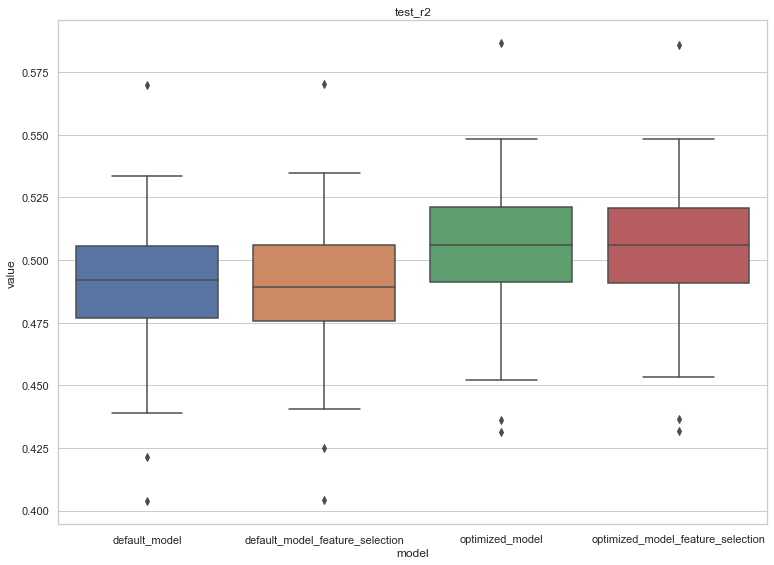

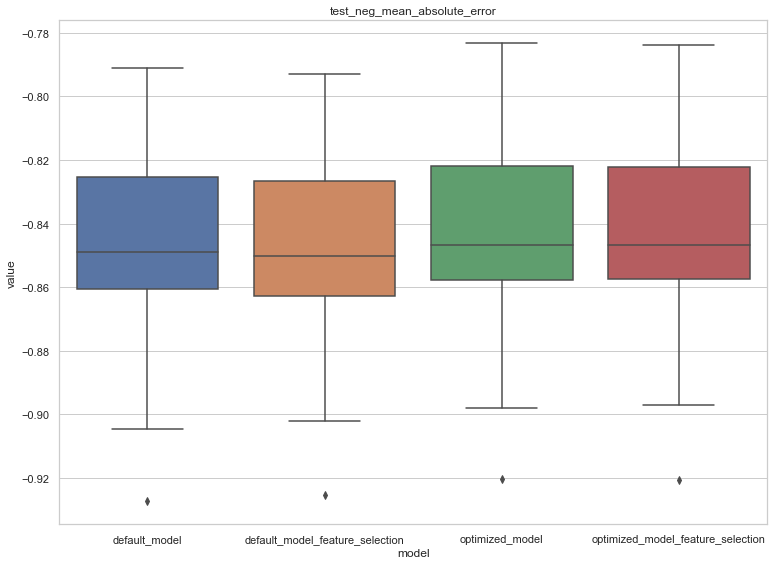

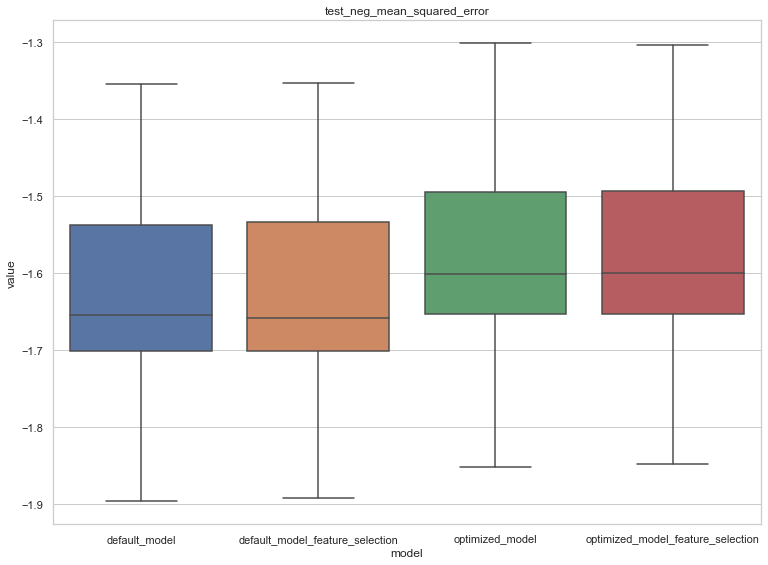

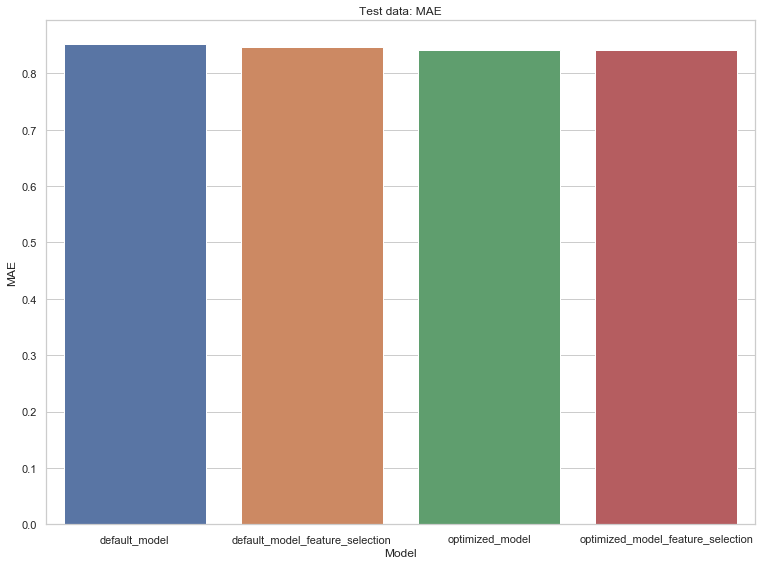

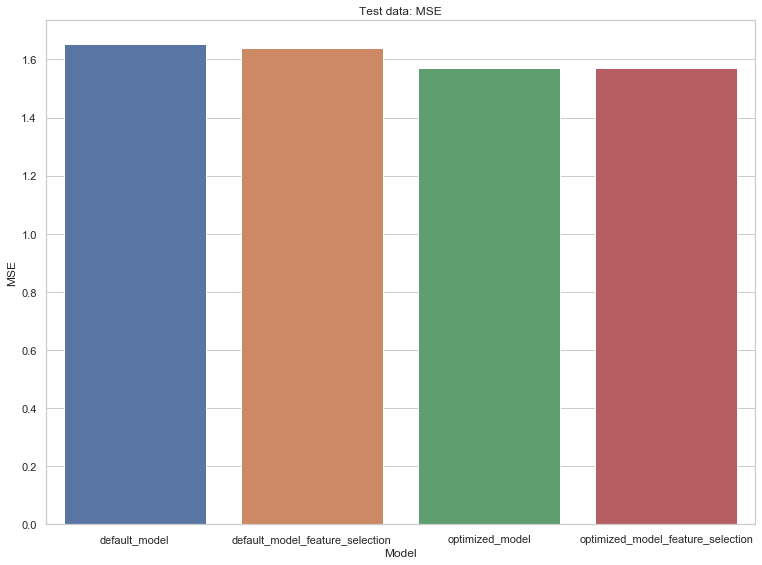

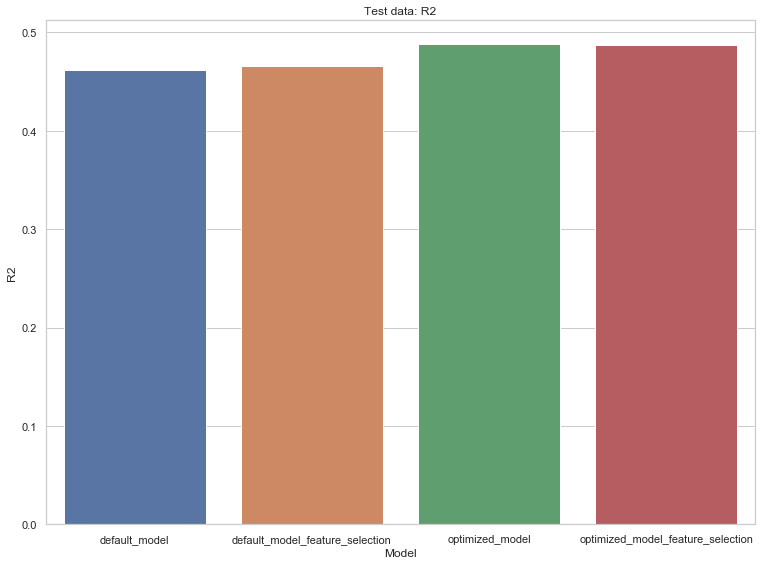

In [7]:


def drop_preselected_columns(X):
    return X[:, selector.support_]


final_pipelines = {
    "default_model": make_pipeline(
        VarianceThreshold(), RandomForestRegressor(n_estimators=100)
    ),
    "default_model_feature_selection": make_pipeline(
        VarianceThreshold(),
        FunctionTransformer(drop_preselected_columns, validate=False),
        RandomForestRegressor(n_estimators=100),
    ),
    "optimized_model": make_pipeline(
        VarianceThreshold(),
        RandomForestRegressor(
            n_estimators=667, max_depth=12, min_samples_split=4, n_jobs=3
        ),
    ),
    "optimized_model_feature_selection": make_pipeline(
        VarianceThreshold(),
        FunctionTransformer(drop_preselected_columns, validate=False),
        RandomForestRegressor(
            n_estimators=667, max_depth=12, min_samples_split=4, n_jobs=3
        ),
    ),
}

scores_optimized = crossvalidate_pipeline_scores(
    X=X_train,
    y=y_train,
    pipelines=final_pipelines,
    n_splits=30,
    random_state=random_state,
)

plot_scores(scores=scores_optimized)

train_and_plot_prediction_metrics(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    pipelines=final_pipelines,
)
